<a href="https://colab.research.google.com/github/danielegenta/Progetto-MLDL/blob/classifiers/main_icarl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
"""
  Following the iCaRL paper specifications.
  ...documentation ...
"""

'\n  Following the iCaRL paper specifications.\n  ...documentation ...\n'

In [0]:
"""!pip3 install 'torch==1.3.1'
!pip3 install 'torchvision==0.5.0'
!pip3 install 'Pillow-SIMD'
!pip3 install 'tqdm'"""
# !pip install --upgrade wandb

"!pip3 install 'torch==1.3.1'\n!pip3 install 'torchvision==0.5.0'\n!pip3 install 'Pillow-SIMD'\n!pip3 install 'tqdm'"

In [0]:
import os
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn

import torchvision
from torchvision import transforms

from PIL import Image
from tqdm import tqdm
import random


import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import time

from sklearn.metrics import confusion_matrix
import math

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
DATA_DIR = 'DATA' # here the dataset will be downloaded

# Clone github repository with dataset handler
!rm -r Cifar100/
!rm -r $DATA_DIR
!mkdir "DATA"
if not os.path.isdir('./Cifar100'):
  !git clone https://github.com/danielegenta/Progetto-MLDL.git
  !mv 'Progetto-MLDL' 'Cifar100'
  !rm -r Cifar100/Theoretical-Sources
  !rm -rf Cifar100/ProjectMLDL.ipynb

rm: cannot remove 'Cifar100/': No such file or directory
rm: cannot remove 'DATA': No such file or directory
Cloning into 'Progetto-MLDL'...
remote: Enumerating objects: 42, done.
remote: Counting objects: 100% (42/42), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 2161 (delta 19), reused 34 (delta 13), pack-reused 2119
Receiving objects: 100% (2161/2161), 18.01 MiB | 16.93 MiB/s, done.
Resolving deltas: 100% (1285/1285), done.


dataset

In [0]:
# Download dataset from the official source and save it into DATA/cifar-100-pyhton

if not os.path.isdir('./{}/cifar-100-python'.format(DATA_DIR)):
    !wget https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
    !tar -xf 'cifar-100-python.tar.gz'  
    !mkdir $DATA_DIR
    !mv 'cifar-100-python' "$DATA_DIR/cifar-100-python"
    !rm -rf 'cifar-100-python.tar.gz

--2020-06-13 16:17:11--  https://www.cs.toronto.edu/~kriz/cifar-100-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 169001437 (161M) [application/x-gzip]
Saving to: ‘cifar-100-python.tar.gz’

cifar-100-python.ta 100%[===================>] 161.17M  30.9MB/s    in 5.8s    

2020-06-13 16:17:17 (27.7 MB/s) - ‘cifar-100-python.tar.gz’ saved [169001437/169001437]

mkdir: cannot create directory ‘DATA’: File exists
/bin/bash: -c: line 0: unexpected EOF while looking for matching `''
/bin/bash: -c: line 1: syntax error: unexpected end of file


In [0]:
from Cifar100 import utils


dictHyperparams = utils.getHyperparams()
print(dictHyperparams)

DEVICE = dictHyperparams["DEVICE"] # 'cuda' or 'cpu'
NUM_CLASSES = dictHyperparams["NUM_CLASSES"] 

BATCH_SIZE = dictHyperparams["BATCH_SIZE"]     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = dictHyperparams["LR"]          # The initial Learning Rate
MOMENTUM = dictHyperparams["MOMENTUM"]       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = dictHyperparams["WEIGHT_DECAY"] # Regularization, you can keep this at the default

NUM_EPOCHS = 70     # Total number of training epochs (iterations over dataset)
GAMMA = dictHyperparams["GAMMA"]         # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = dictHyperparams["LOG_FREQUENCY"]
MILESTONES = dictHyperparams["MILESTONES"]
RANDOM_SEED = 66

# icarl params
herding = True # if false random exemplars, if true nme (herding)
classifier = "NCM" # NCM, FCC, KNN, SVC, COS

{'LR': 2, 'MOMENTUM': 0.9, 'WEIGHT_DECAY': 1e-05, 'NUM_EPOCHS': 70, 'MILESTONES': [49, 63], 'BATCH_SIZE': 128, 'DEVICE': 'cuda', 'GAMMA': 0.2, 'SEED': 66, 'LOG_FREQUENCY': 10, 'NUM_CLASSES': 100}


In [0]:
train_transform, eval_transform = utils.getTransformations()

In [0]:
from Cifar100.Dataset.cifar100 import CIFAR100

# Import dataset
train_dataset = CIFAR100(DATA_DIR, split='train', transform=train_transform)
test_dataset = CIFAR100(DATA_DIR, split='test', transform=eval_transform)

# check if datasets have been correctly loaded
print(len(train_dataset))
print(len(test_dataset))

50000
10000


In [0]:
from Cifar100.reverse_index import ReverseIndex

def build_test_splits(dataset, reverse_index):
    splits = dict()
    groups = list(reverse_index.getGroups())
    for g in groups:
        labels_of_groups = reverse_index.getLabelsOfGroup(g)
        indices = list(dataset.df[dataset.df['labels'].isin(labels_of_groups)].index)
        splits[g] = indices
    return splits

In [0]:
# performing the train/val split
train_splits = train_dataset.split_in_train_val_groups(ratio=1, seed=RANDOM_SEED)
outputs_labels_mapping = ReverseIndex(train_dataset, train_splits)

# performing the test split (coherent with train/val)
test_splits = build_test_splits(test_dataset, outputs_labels_mapping)

In [0]:
# Dataloaders iterate over pytorch datasets and transparently provide useful functions (e.g. parallelization and shuffling)
train_subsets = []
val_subsets = []
test_subsets = []

for v in train_splits.values():
    train_subs = Subset(train_dataset, v['train'])
    #val_subs = Subset(train_dataset, v['val'])
    train_subsets.append(train_subs)
    #val_subsets.append(val_subs)

for i in range(0,10): # for each group of classes
    v=test_splits[i]
    test_subs = Subset(test_dataset, v)
    test_subsets.append(test_subs)

In [0]:
def computeAccuracy(method, net, loader, reverse_index, dataset, all_preds_cm, all_labels_cm):
  total = 0.0
  correct = 0.0
  for indices, images, labels in loader:
        images = images.to(DEVICE)
        labels = labels.to(DEVICE)
     
        # add other classifiers
        if classifier == 'NCM':
          labels = reverse_index.getNodes(labels)
          preds = net.classify(images)
        elif classifier == 'FCC':
          labels = reverse_index.getNodes(labels)
          preds = net.FCC_classify(images)
        elif classifier == 'KNN' or classifier == 'SVC':
          preds = net.KNN_SVC_classify(images)
          preds = preds.to(DEVICE)
        elif classifier == 'COS':
          labels = reverse_index.getNodes(labels)
          preds = net.COS_classify(images)

        correct += torch.sum(preds == labels.data).data.item()
  accuracy = correct/len(dataset)
  if method == 'test':
    all_preds_cm.extend(preds.tolist())
    all_labels_cm.extend(labels.data.tolist())
  return accuracy, all_preds_cm, all_labels_cm

In [0]:
def incrementalTraining(icarl, train_subsets, val_subsets, test_subsets,eval_transform, reverse_index, K):
    
    all_accuracies = []
    all_preds_cm = []
    all_labels_cm = []
    group_id=1
    test_set = None

    #for train_subset, val_subset, test_subset in zip(train_subsets, val_subsets, test_subsets):
    for train_subset, test_subset in zip(train_subsets, test_subsets):
        print("GROUP: ",group_id)
        if test_set is None:
          test_set = test_subset
          train_set_big = train_subset
        else:
          test_set = utils.joinSubsets(test_dataset, [test_set, test_subset])

        train_dataloader = DataLoader(train_subset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
        #val_dataloader = DataLoader(val_subset, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)
        test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE,shuffle=True, num_workers=4)

        ####### iCaRL implementation(following alg. 2,3,4,5 on icarl paper) ##################
        
        new_classes_examined = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
        
        # 1 - update representation of the net 
        #  alg. 3 icarl
        # (here the trainset will be augmented with the exemplars too)
        # (here the classes are incremented too)
        icarl.update_representation(train_subset, train_dataset, new_classes_examined)

        # 2 - update m (number of images per class in the exemplar set corresponding to that class)
        m = int(math.ceil(K/icarl.n_classes))

        print("Reducing each exemplar set to size: {}".format(m))

        # 3 - reduce exemplar set for all the previously seen classes
        # alg.5 icarl
        icarl.reduce_exemplar_sets(m)

        # retrieve the 10 classes in the current subset
        # NB. Here there will be exemplars too! (if i do not want that, use new_classes_examined)
        classes_current_subset = list(train_dataset.df.loc[train_subset.indices, 'labels'].value_counts().index)
        
        print("Constructing exemplar sets class...")
        
        # 4 - construct the exemplar set for the new classes
        for y in new_classes_examined: # for each class in the current subset
          
          
          # extract all the imgs in the train subset that are linked to this class
          images_current_class = train_subset.dataset.df.loc[train_dataset.df['labels'] == y, 'data'] #they're TENSORS NOT IMAGES (the conversion will be done later)         
          imgs_idxs = images_current_class.index # the indexes of all the images in the current classe being considered 0...49k
          class_train_subset = Subset(train_dataset, imgs_idxs)#subset of the train dataset where i have all the imgs of class y

          # alg. 4 icarl
          icarl.construct_exemplar_set(class_train_subset,m,y)

        # update the num classes seen so far
        icarl.n_known = icarl.n_classes #n_classes is incremented in 1: updateRepresentation

        print("Performing classification...")

        # start classifier
        icarl.computeMeans()

        # common training on exemplars for KNN and SVC classifier
        if classifier == 'KNN':
          K_nn = 5
          icarl.modelTrain(classifier, K_nn)
        elif classifier == 'SVC':
          icarl.modelTrain(classifier)

        #train accuracy
        train_accuracy, _, _ = computeAccuracy('train',icarl, train_dataloader, reverse_index, train_subset,all_preds_cm, all_labels_cm)
        print ('Train Accuracy (on current group): %.2f\n' % (100.0 * train_accuracy))

        # --- not used
        #val_accuracy, _, _ = computeAccuracy('val',icarl, val_dataloader, reverse_index, val_subset)
        #print ('Val Accuracy (on current group): %.2f\n' % (100.0 * val_accuracy))

        #test
        test_accuracy, all_preds_cm, all_labels_cm = computeAccuracy('test',icarl, test_dataloader, reverse_index, test_set, all_preds_cm, all_labels_cm)
        all_accuracies.append(test_accuracy)
        print ('Test Accuracy (all groups seen so far): %.2f\n' % (100.0 * test_accuracy))

        print ("the model knows %d classes:\n " % icarl.n_known)

        group_id+=1
        
    return all_accuracies, np.array(all_preds_cm), np.array(all_labels_cm)

In [0]:
"""
    This class implements the main model of iCaRL 
    and all the methods regarding the exemplars
    from delivery: iCaRL is made up of 2 components
    - feature extractor (a convolutional NN) => resnet32 optimized on cifar100
    - classifier => a FC layer OR a non-parametric classifier (NME)
"""

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
from PIL import Image
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torch.autograd import Variable
import copy
import gc #extensive use in order to manage memory issues
from torchvision import transforms
from PIL import Image
from torchvision.transforms import ToPILImage 

from Cifar100 import utils
from Cifar100.resnet import resnet32
from Cifar100.Dataset.cifar100 import CIFAR100
import random
import pandas as pd

# new classifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC

def auto_loss_rebalancing(n_known, n_classes, loss_type):
  alpha = n_known/n_classes 

  if loss_type == 'class':
    return 1-alpha
  return alpha

def get_rebalancing(rebalancing=None):
  if rebalancing is None:
    return lambda n_known, n_classes, loss_type: 1
  if rebalancing in ['auto', 'AUTO']:
    return auto_loss_rebalancing
  if callable(rebalancing):
    return rebalancing

# feature_size: 2048, why?
# n_classes: 10 => 100
class ICaRL(nn.Module):
  def __init__(self, feature_size, n_classes,\
      BATCH_SIZE, WEIGHT_DECAY, LR, GAMMA, NUM_EPOCHS, DEVICE, MILESTONES, MOMENTUM, K,\
      herding, reverse_index = None, class_loss_criterion='bce', dist_loss_criterion='bce', loss_rebalancing='auto', lambda0=1):
    super(ICaRL, self).__init__()
    self.net = resnet32()
    self.net.fc = nn.Linear(self.net.fc.in_features, n_classes)

    self.feature_extractor = resnet32()
    self.feature_extractor.fc = nn.Sequential()

    self.n_classes = n_classes
    self.n_known = 0

    # Hyper-parameters from iCaRL
    self.BATCH_SIZE = BATCH_SIZE
    self.WEIGHT_DECAY  = WEIGHT_DECAY
    self.LR = LR
    self.GAMMA = GAMMA # this allow LR to become 1/5 LR after MILESTONES epochs
    self.NUM_EPOCHS = NUM_EPOCHS
    self.DEVICE = DEVICE
    self.MILESTONES = MILESTONES # when the LR decreases, according to icarl
    self.MOMENTUM = MOMENTUM
    self.K = K
    
    self.reverse_index=reverse_index

    self.optimizer, self.scheduler = utils.getOptimizerScheduler(self.LR, self.MOMENTUM, self.WEIGHT_DECAY, self.MILESTONES, self.GAMMA, self.parameters())

    gc.collect()
    
    # List containing exemplar_sets
    # Each exemplar_set is a np.array of N images
    self.exemplar_sets = []
    self.exemplar_sets_indices = []

    
    # for the classification/distillation loss we have two alternatives
    # 1- BCE loss with Logits (reduction could be mean or sum)
    # 2- BCE loss + sigmoid
    # actually we use just one loss as explained on the forum

    self.class_loss, self.dist_loss = self.build_loss(class_loss_criterion, dist_loss_criterion, loss_rebalancing, lambda0=lambda0)

    # Means of exemplars (cntroids)
    self.compute_means = True
    self.exemplar_means = []
    self.exemplar_mean_nn = [] # means not normalized

    self.herding = herding # random choice of exemplars or icarl exemplars strategy?

    # this is used as explained in the forum to compute the exemplar mean in a more accurate way
    # populated during construct exemplar set and used in the classify step
    self.data_from_classes = []
    self.means_from_classes = []

    # Knn, svc classification
    self.model = None

    # QUA! #
    ###############################################################################################################################################################################################
    self.oldNet= None
    self.moreOldNet= None

    ###############################################################################################################################################################################################
  
  # increment the number of classes considered by the net
  # incremental learning approach, 0,10..100
  def increment_classes(self, n):
        gc.collect()

        in_features = self.net.fc.in_features
        out_features = self.net.fc.out_features
        weights = self.net.fc.weight.data
        bias = self.net.fc.bias.data

        self.net.fc = nn.Linear(in_features, out_features + n) #add 10 classes to the fc last layer
        self.net.fc.weight.data[:out_features] = weights
        self.net.fc.bias.data[:out_features] = bias
        self.n_classes += n #icrement #classes considered

  # computes the mean of each exemplar set
  def computeMeans(self):
    torch.no_grad()  
    torch.cuda.empty_cache()

    feature_extractor = self.feature_extractor.to(self.DEVICE)
    feature_extractor.train(False)

    # new mean mgmt
    tensors_mean = []
    exemplar_mean_nn=[]
    with torch.no_grad():
      for tensor_set in self.data_from_classes:
        features = []
        for tensor, _ in tensor_set:
          
          tensor = tensor.to(self.DEVICE)
          feature = feature_extractor(tensor)

          feature.data = feature.data / feature.data.norm() # Normalize
          features.append(feature)

          # cleaning 
          torch.no_grad()
          torch.cuda.empty_cache()

        features = torch.stack(features) #(num_exemplars,num_features)
        mean_tensor = features.mean(0) 
        exemplar_mean_nn.append(mean_tensor.to('cpu'))
        mean_tensor.data = mean_tensor.data / mean_tensor.data.norm() # Re-normalize
        mean_tensor = mean_tensor.to('cpu')
        tensors_mean.append(mean_tensor)

    self.exemplar_means = tensors_mean  # nb the mean is computed over all the imgs
    self.exemplar_mean_nn= exemplar_mean_nn # exemplars means not normalized

    # cleaning
    torch.no_grad()  
    torch.cuda.empty_cache()

  # train procedure common for KNN and SVC classifier (save a lot of training time)
  def modelTrain(self, method, K_nn = None):
    torch.no_grad()
    torch.cuda.empty_cache()

    feature_extractor = self.feature_extractor.to(self.DEVICE)
    feature_extractor.train(False)

    # -- train a SVC classifier
    X_train, y_train = [], []

    for exemplar_set in self.exemplar_sets:
          for exemplar, label in  exemplar_set:
            exemplar = exemplar.to(self.DEVICE)
            feature = feature_extractor(exemplar)
            feature = feature.squeeze()
            feature.data = feature.data / feature.data.norm() # Normalize
            X_train.append(feature.cpu().detach().numpy())
            y_train.append(label)
    
    if method == 'KNN':
      model = KNeighborsClassifier(n_neighbors = K_nn)
    elif method == 'SVC':
      model = LinearSVC()
    self.model = model.fit(X_train, y_train)

  # common classify function
  def KNN_SVC_classify(self, images):
    torch.no_grad()
    torch.cuda.empty_cache()

    # --- prediction
    X_pred = []
    images = images.to(self.DEVICE)
    feature_extractor = self.feature_extractor.to(self.DEVICE)
    feature_extractor.train(False)

    features = feature_extractor(images)
    for feature in features:
      feature = feature.squeeze()
      feature.data = feature.data / feature.data.norm() # Normalize
      X_pred.append(feature.cpu().detach().numpy())
    
    preds = self.model.predict(X_pred)
    # --- end prediction
    return torch.tensor(preds)
    
  # classify base on cosine similarity
  def COS_classify(self, batch_imgs):
    torch.no_grad()
    torch.cuda.empty_cache()
    batch_imgs_size = batch_imgs.size(0)
    feature_extractor = self.feature_extractor.to(self.DEVICE)
    feature_extractor.train(False)

    means_exemplars = torch.cat(self.exemplar_mean_nn, dim=0)
    means_exemplars = torch.stack([means_exemplars] * batch_imgs_size)
    means_exemplars = means_exemplars.transpose(1, 2) # means no normalized

    feature = feature_extractor(batch_imgs) # features no normalized
    
    feature=feature.to('cpu')
    means_exemplars = means_exemplars.to('cpu')

    preds=[]
    for a in feature:
      a=a.detach().numpy()
      aa=np.linalg.norm(a)
      res=[]
      for b in means_exemplars:
        b=b.detach().numpy()
        bb=np.linalg.norm(b)
        dot = np.dot(a, b)
        cos = dot / (aa * bb)
        res.append(cos)
      preds.append(np.argmax(np.array(res)))

    # cleaning
    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()

    return torch.FloatTensor(preds).to(self.DEVICE)

  # classification via fc layer (similar to lwf approach)
  def FCC_classify(self, images):
    _, preds = torch.max(torch.softmax(self.net(images), dim=1), dim=1, keepdim=False)
    return preds
  # NME classification from iCaRL paper
  def classify(self, batch_imgs):
      """Classify images by nearest-mean-of-exemplars
      Args:
          batch_imgs: input image batch
      Returns:
          preds: Tensor of size (batch_size,)
      """
      torch.no_grad()
      torch.cuda.empty_cache()

      batch_imgs_size = batch_imgs.size(0)
      feature_extractor = self.feature_extractor.to(self.DEVICE)
      feature_extractor.train(False)

      # update exemplar_means with the mean
      # of all the train data for a given class

      means_exemplars = torch.cat(self.exemplar_means, dim=0)
      means_exemplars = torch.stack([means_exemplars] * batch_imgs_size)
      means_exemplars = means_exemplars.transpose(1, 2) 

      feature = feature_extractor(batch_imgs) 
      aus_normalized_features = []
      for el in feature: # Normalize
          el.data = el.data / el.data.norm()
          aus_normalized_features.append(el)

      feature = torch.stack(aus_normalized_features,dim=0)

      feature = feature.unsqueeze(2) 
      feature = feature.expand_as(means_exemplars) 

      means_exemplars = means_exemplars.to(self.DEVICE)

      # Nearest prototype
      preds = torch.argmin((feature - means_exemplars).pow(2).sum(1),dim=1)

      # cleaning
      torch.no_grad()
      torch.cuda.empty_cache()
      gc.collect()

      return preds

  # implementation of alg. 4 of icarl paper
  # iCaRL ConstructExemplarSet
  def construct_exemplar_set(self, tensors, m, label):
    """
      Args:
          tensors: train_subset containing a single label
          m: number of exemplars allowed/exemplar set (class)
          label: considered class
    """
    torch.no_grad()
    torch.cuda.empty_cache()
    gc.collect()

    exemplar_set_indices = set()
    exemplar_list_indices = []
    exemplar_set = []
    if self.herding:

      feature_extractor = self.feature_extractor.to(self.DEVICE)
      feature_extractor.train(False)

      # Compute and cache features for each example
      features = []

      loader = DataLoader(tensors,batch_size=self.BATCH_SIZE,shuffle=True,drop_last=False,num_workers = 4)

      with torch.no_grad():
        for _, images, labels in loader:
          images = images.to(self.DEVICE)
          labels = labels.to(self.DEVICE)
          feature = feature_extractor(images) 

          feature = feature / np.linalg.norm(feature.cpu()) # Normalize
          
          features.append(feature)

      features_s = torch.cat(features)
      
      class_mean = features_s.mean(0)
      class_mean = class_mean / np.linalg.norm(class_mean.cpu()) # Normalize
      class_mean = torch.stack([class_mean]*features_s.size()[0])

      summon = torch.zeros(1,features_s.size()[1]).to(self.DEVICE) #(1,num_features)
      for k in range(1, (m + 1)):
          S = torch.cat([summon]*features_s.size()[0]) # second addend, features in the exemplar set
          results = pd.DataFrame((class_mean-(1/k)*(features_s + S)).pow(2).sum(1).cpu(), columns=['result']).sort_values('result')
          results['index'] = results.index
          results = results.to_numpy()

          # select argmin not included in exemplar_set_indices
          for i in range(results.shape[0]):
            index = results[i, 1]
            exemplar_k_index = tensors[index][0]
            if exemplar_k_index not in exemplar_set_indices:
              exemplar_k = tensors[index][1].unsqueeze(dim = 0) # take the image from the tuple (index, img, label)
              exemplar_set.append((exemplar_k, label))
              exemplar_k_index = tensors[index][0] # index of the img on the real dataset
              
              exemplar_list_indices.append(exemplar_k_index)
              exemplar_set_indices.add(exemplar_k_index)
              break

          # features of the exemplar k
          phi = feature_extractor(exemplar_k.to(self.DEVICE)) #feature_extractor(exemplar_k.to(self.DEVICE))
          summon += phi # update sum of features
    else:
      tensors_size = len(tensors)
      unique_random_indexes = random.sample(range(0, tensors_size), m) # random sample without replacement k exemplars
      i = 0
      for k in range(1, (m + 1)):
        index = unique_random_indexes[i]
        exemplar_k = tensors[index][1].unsqueeze(dim = 0)
        exemplar_k_index = tensors[index][0]
        exemplar_set.append((exemplar_k, label))
        exemplar_set_indices.add(exemplar_k_index)
        i = i + 1

    # --- new ---
    tensor_set = []
    for i in range(0, len(tensors)):
      t = tensors[i][1].unsqueeze(dim = 0)
      tensor_set.append((t, label))
    
    self.exemplar_sets.append(exemplar_set) #update exemplar sets with the updated exemplars images
    self.exemplar_sets_indices.append(exemplar_list_indices)

    # this is used to compute more accurately the means of the exemplar (see also computeMeans and classify)
    self.data_from_classes.append(tensor_set)

    # cleaning
    torch.cuda.empty_cache()

  # build a exemplar dataset as a subset of the train dataset
  def build_exemplars_dataset(self, train_dataset): #complete train dataset
    all_exemplars_indices = []
    for exemplar_set_indices in self.exemplar_sets_indices:
        all_exemplars_indices.extend(exemplar_set_indices)

    exemplars_dataset = Subset(train_dataset, all_exemplars_indices)
    return exemplars_dataset

  def update_representation(self, dataset, train_dataset_big, new_classes):
    # 1 - retrieve the classes from the dataset (which is the current train_subset)
    # 2 - retrieve the new classes
    # 1,2 are done in the main_icarl
    #gc.collect()

    # 3 - increment classes
    #          (add output nodes)
    #          (update n_classes)
    # 5        store network outputs with pre-update parameters
    self.increment_classes(len(new_classes))

    # 4 - combine current train_subset (dataset) with exemplars
    #     to form a new augmented train dataset
    # join the datasets
    exemplars_dataset = self.build_exemplars_dataset(train_dataset_big)
    
    ######################################################################################
  
    if self.n_known==0:
      cut=0
    else:
      cut=self.n_known/10
    new_dataset_size = 5000 - int(math.ceil(450*cut))
    unique_random_indexes = random.sample(range(0, len(dataset)), new_dataset_size) # random sample without replacement
    new_dataset=torch.utils.data.Subset(dataset, unique_random_indexes)

    # trying to save the images in a list
    new_classes_dataset=[]
    loader_imgs = DataLoader(new_dataset, batch_size=self.BATCH_SIZE, shuffle = False, num_workers=4)
    for __, images, labels in loader_imgs:
      for img, label in zip(images, labels):
        new_classes_dataset.append((0, img, label))

    #print("NEW CLASS SAMPLES: ",len(new_dataset))
    ######################################################################################
    #
    if len(exemplars_dataset) > 0:
      #join_dataset = ConcatDataset(new_dataset, exemplars_dataset)
      #augmented_dataset = ConcatDataset(join_dataset, exemplars_dataset)
      
      load_exemplars = DataLoader(exemplars_dataset, batch_size=self.BATCH_SIZE, shuffle = False, num_workers=4)
      new_image = []
      old_image = []
      for _, images, labels in load_exemplars:
        for img,lab in zip(images,labels):
          tran = transforms.Compose([transforms.ToPILImage(),transforms.RandomVerticalFlip(p=0.7),transforms.RandomGrayscale(p=0.7),transforms.ToTensor()])
          new_img = tran(img)
          new_image.append((0, new_img, lab))
          old_image.append((0, img, lab))

      #new_classes_dataset.extend(new_image)
      #new_classes_dataset.extend(old_image)

      augmented_dataset = new_classes_dataset+new_image+old_image

      
      #augmented_dataset = ConcatDataset(dataset, exemplars_dataset)
      #augmented_dataset = utils.joinSubsets(train_dataset_big, [dataset, exemplars_dataset])
    else: 
      augmented_dataset = new_classes_dataset # first iteration

    print("ALL DB: ",len(augmented_dataset))
    # 6 - run network training, with loss function

    net = self.net

    optimizer = optim.SGD(net.parameters(), lr=self.LR, weight_decay=self.WEIGHT_DECAY, momentum=self.MOMENTUM)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=self.MILESTONES, gamma=self.GAMMA, last_epoch=-1)

    criterion = utils.getLossCriterion()

    cudnn.benchmark # Calling this optimizes runtime
    net = net.to(self.DEVICE)

    # define the loader for the augmented_dataset
    l = DataLoader(augmented_dataset, batch_size=self.BATCH_SIZE,shuffle=True, num_workers=4, drop_last = True)

    
    if len(self.exemplar_sets) > 0:
      # QUA! #
      #########################################################################################

      #   print(self.oldNetTeachers[1].size())
      if self.oldNet!=None:
        self.moreOldNet=self.oldNet
      self.oldNet= copy.deepcopy(net)

      #########################################################################################
    for epoch in range(self.NUM_EPOCHS):
        print("NUM_EPOCHS: ",epoch,"/", self.NUM_EPOCHS," LR: ",scheduler.get_lr())
        for indices, images, labels in l:
            # Bring data over the device of choice
            images = images.to(self.DEVICE)
            labels = labels.to(self.DEVICE)
            net.train()
            # PyTorch, by default, accumulates gradients after each backward pass
            # We need to manually set the gradients to zero before starting a new iteration
            optimizer.zero_grad() # Zero-ing the gradients
            
 
            # QUA! #
            #############################################################################################################
            # Forward pass to the network
            outputs = net(images)
            # Loss = only classification on new classes
            loss = self.class_loss(outputs, labels, col_start=self.n_known)
            class_loss = loss.item() # Used for logging for debugging purposes
            
            # Distilation loss for old classes, class loss on new classes
            dist_loss = None
            older_dist_loss=None
            if len(self.exemplar_sets) > 0:
              old_net=self.oldNet
              out_old = torch.sigmoid(old_net(images))
              dist_loss = self.dist_loss(outputs, out_old, col_end=self.n_known)

              if self.moreOldNet!=None:
                older_net=self.moreOldNet # old old net
                older_out = torch.sigmoid(older_net(images))
                older_dist_loss = self.double_dist_loss(outputs[0:128,0:-20], older_out[0:128,0:-10], col_end=self.n_known)
                loss += older_dist_loss

              loss += dist_loss

            loss.backward()
            optimizer.step()
            ##############################################################################################################

        scheduler.step()
        print("LOSS: ", loss.item(), 'class loss', class_loss, 'dist loss', dist_loss.item() if dist_loss is not None else dist_loss, 'older dist loss',older_dist_loss.item() if older_dist_loss is not None else older_dist_loss)

    self.net = copy.deepcopy(net)
    self.feature_extractor = copy.deepcopy(net)
    self.feature_extractor.fc = nn.Sequential()

    #cleaning
    del net
    torch.cuda.empty_cache()
 # QUA! #
 ###################################################################################################################
  def double_dist_loss(self,outputs, labels, row_start=None, row_end=None, col_start=None, col_end=None):
    rebalancing=None
    rebalancing = get_rebalancing(rebalancing)
    dist_loss_func = self.bce_dist_loss
    alpha = rebalancing(self.n_known, self.n_classes, 'dist')
    return 0.5*alpha*dist_loss_func(outputs, labels, row_start=row_start, row_end=row_end, col_start=col_start, col_end=col_end)
 ##################################################################################################################

  def build_loss(self, class_loss_criterion, dist_loss_criterion, rebalancing=None, lambda0=1):
    class_loss_func = None
    dist_loss_func = None

    if class_loss_criterion in ['l2', 'L2']:
      class_loss_func = self.l2_class_loss
    elif class_loss_criterion in ['bce', 'BCE']:
      class_loss_func = self.bce_class_loss
    elif class_loss_criterion in ['ce', 'CE']:
      class_loss_func = self.ce_class_loss

    if dist_loss_criterion in ['l2', 'L2']:
      dist_loss_func = self.l2_dist_loss
    elif dist_loss_criterion in ['bce', 'BCE']:
      dist_loss_func = self.bce_dist_loss
    elif dist_loss_criterion in ['ce', 'CE']:
      dist_loss_func = self.ce_dist_loss

    rebalancing = get_rebalancing(rebalancing)
    
    def class_loss(outputs, labels, row_start=None, row_end=None, col_start=None, col_end=None):
      alpha = rebalancing(self.n_known, self.n_classes, 'class')
      return alpha*class_loss_func(outputs, labels, row_start=row_start, row_end=row_end, col_start=col_start, col_end=col_end)
    
    def dist_loss(outputs, labels, row_start=None, row_end=None, col_start=None, col_end=None):
      alpha = rebalancing(self.n_known, self.n_classes, 'dist')
      return lambda0*alpha*dist_loss_func(outputs, labels, row_start=row_start, row_end=row_end, col_start=col_start, col_end=col_end)
    
    return class_loss, dist_loss

  def bce_class_loss(self, outputs, labels, row_start=None, row_end=None, col_start=None, col_end=None):
    return self.bce_loss(outputs, labels, encode=True, row_start=row_start, row_end=row_end, col_start=col_start, col_end=col_end)

  def bce_dist_loss(self, outputs, labels, row_start=None, row_end=None, col_start=None, col_end=None):
    return self.bce_loss(outputs, labels, encode=False, row_start=row_start, row_end=row_end, col_start=col_start, col_end=col_end)

  def ce_class_loss(self, outputs, labels, row_start=None, row_end=None, col_start=None, col_end=None):
    return self.ce_loss(outputs, self.reverse_index.getNodes(labels), decode=False, row_start=row_start, row_end=row_end, col_start=None, col_end=col_end)
    
  def ce_dist_loss(self, outputs, labels, row_start=None, row_end=None, col_start=None, col_end=None):
    return self.ce_loss(outputs, labels, decode=True, row_start=row_start, row_end=row_end, col_start=col_start, col_end=col_end)

  def l2_class_loss(self, outputs, labels, row_start=None, row_end=None, col_start=None, col_end=None):
    return self.l2_loss(outputs, labels, encode=True, row_start=row_start, row_end=row_end, col_start=col_start, col_end=col_end)

  def l2_dist_loss(self, outputs, labels, row_start=None, row_end=None, col_start=None, col_end=None):
    return self.l2_loss(outputs, labels, encode=False, row_start=row_start, row_end=row_end, col_start=col_start, col_end=col_end)


  def bce_loss(self, outputs, labels, encode=False, row_start=None, row_end=None, col_start=None, col_end=None):
    criterion = nn.BCEWithLogitsLoss(reduction = 'mean')

    if encode:
      labels = utils._one_hot_encode(labels, self.n_classes, self.reverse_index, device=self.DEVICE)
      labels = labels.type_as(outputs)

    return criterion(outputs[row_start:row_end, col_start:col_end], labels[row_start:row_end, col_start:col_end])


  def ce_loss(self, outputs, labels, decode=False, row_start=None, row_end=None, col_start=None, col_end=None):
    criterion = nn.CrossEntropyLoss()

    if decode:
      labels = torch.argmax(labels, dim=1)
    
    return criterion(outputs[row_start:row_end, col_start:col_end], labels[row_start:row_end])


  def l2_loss(self, outputs, labels, encode=False, row_start=None, row_end=None, col_start=None, col_end=None):
    criterion = nn.MSELoss(reduction = 'mean')
    
    if encode:
      labels = utils._one_hot_encode(labels, self.n_classes, self.reverse_index, device=self.DEVICE)
      labels = labels.type_as(outputs)
    
    return criterion(outputs[row_start:row_end, col_start:col_end], labels[row_start:row_end, col_start:col_end])


  # implementation of alg. 5 of icarl paper
  # iCaRL ReduceExemplarSet
  def reduce_exemplar_sets(self, m):
  	    # i keep only the first m exemplar images
        # where m is the UPDATED K/number_classes_seen
        # the number of images per each exemplar set (class) progressively decreases
        for y, P_y in enumerate(self.exemplar_sets):
            self.exemplar_sets[y] = P_y[:m] 
        for x, P_x in enumerate(self.exemplar_sets_indices):
            self.exemplar_sets_indices[x] = P_x[:m] 


# ---------- 
from torch.utils.data import Dataset
"""
  Merge two different datasets (train and exemplars in our case)
  format:
  train
  --------
  exemplars
  train leans on cifar100
  exemplars is managed here (exemplar_transform is performed) => changed
"""
class ConcatDataset(Dataset):
    
    def __init__(self, dataset1, dataset2):
        self.dataset1 = dataset1
        self.dataset2 = dataset2
        self.l1 = len(dataset1)
        self.l2 = len(dataset2)

    def __getitem__(self,index):
        if index < self.l1:
            _, image,label = self.dataset1[index] #here it leans on cifar100 get item
            return _, image,label
        else:
            _, image, label = self.dataset2[index - self.l1]
            return _, image,label

    def __len__(self):
        return (self.l1 + self.l2)
#------------

**Exemplars management**<br>
From iCaRL. We have an exemplar set for each class that we have seen so far. The cardinality of each exemplar set is constant and it is equal, at any time, to m = K/t. Where K is a constraint equal to the amount of memory we're allocating for the exemplars and t is the number of classes that has been seen so far. Implementing iCaRL, whenever a group of (10) classes is trained, it is trained on the train data for those classes (as before) + the current exemplars sets.*italicized text*

In [103]:
#from Cifar100.icarl_model import ICaRL

# default params

K = 2000
n_classes = 0
feature_size = 2048

icarl = ICaRL(feature_size, n_classes, BATCH_SIZE, WEIGHT_DECAY, LR, GAMMA, NUM_EPOCHS, DEVICE,MILESTONES,MOMENTUM, K, herding, outputs_labels_mapping)
icarl.cuda() 

ICaRL(
  (net): ResNet(
    (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(16, 16, kernel_size=

In [104]:
accuracies, all_preds_cm, all_labels_cm = incrementalTraining(icarl, train_subsets, val_subsets, test_subsets,eval_transform, outputs_labels_mapping, K)

GROUP:  1
ALL DB:  5000
NUM_EPOCHS:  0 / 70  LR:  [2]


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:396: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


LOSS:  0.32529017329216003 class loss 0.32529017329216003 dist loss None older dist loss None
NUM_EPOCHS:  1 / 70  LR:  [2]
LOSS:  0.3132565915584564 class loss 0.3132565915584564 dist loss None older dist loss None
NUM_EPOCHS:  2 / 70  LR:  [2]
LOSS:  0.31138092279434204 class loss 0.31138092279434204 dist loss None older dist loss None
NUM_EPOCHS:  3 / 70  LR:  [2]
LOSS:  0.30321189761161804 class loss 0.30321189761161804 dist loss None older dist loss None
NUM_EPOCHS:  4 / 70  LR:  [2]
LOSS:  0.30343085527420044 class loss 0.30343085527420044 dist loss None older dist loss None
NUM_EPOCHS:  5 / 70  LR:  [2]
LOSS:  0.31456074118614197 class loss 0.31456074118614197 dist loss None older dist loss None
NUM_EPOCHS:  6 / 70  LR:  [2]
LOSS:  0.30319127440452576 class loss 0.30319127440452576 dist loss None older dist loss None
NUM_EPOCHS:  7 / 70  LR:  [2]
LOSS:  0.281195729970932 class loss 0.281195729970932 dist loss None older dist loss None
NUM_EPOCHS:  8 / 70  LR:  [2]
LOSS:  0.27044

metrics iCaRL for seed 66


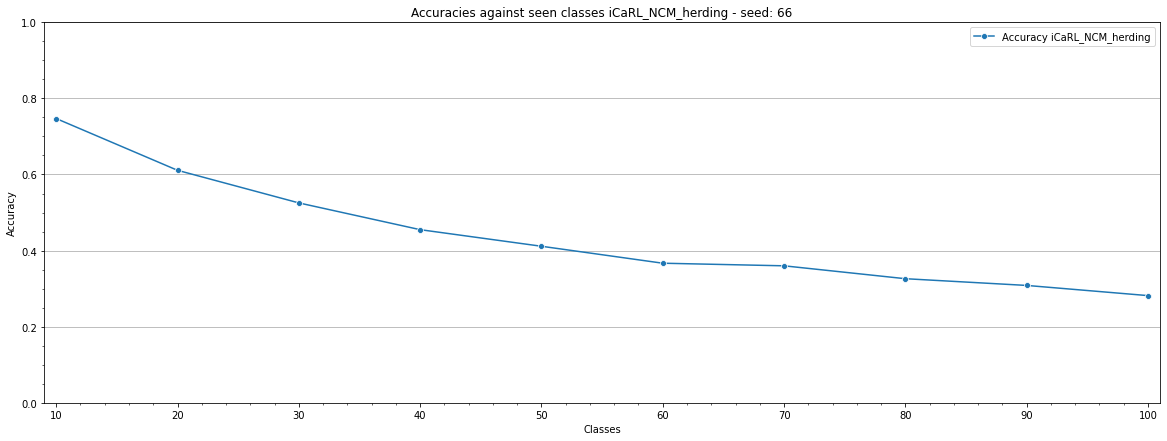

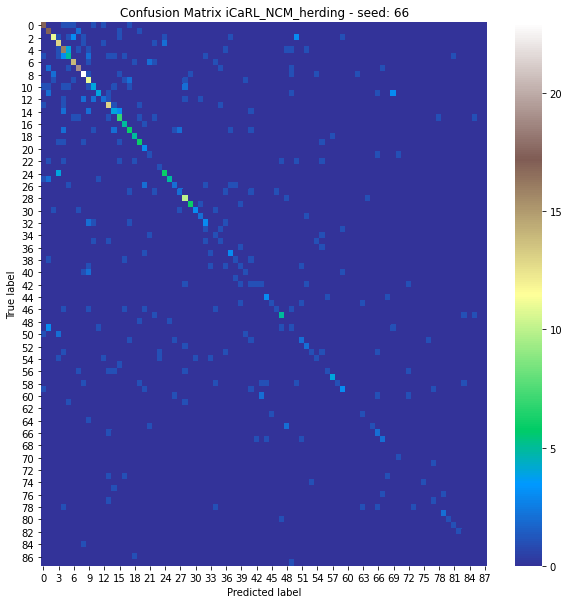

In [105]:
if herding:
  method = 'iCaRL_{}_herding'.format(classifier)
else:
  method = 'iCaRL_{}_random'.format(classifier)

print("metrics iCaRL for seed {}".format(RANDOM_SEED))

# accuracy 
data_plot_line=[]

classes_per_group = 10
for group_classes in range(0,10):
    data_plot_line.append(((group_classes + 1)*classes_per_group, accuracies[group_classes]))

# plot accuracy trend
utils.plotAccuracyTrend(method, data_plot_line, RANDOM_SEED)

# confusion matrix
confusionMatrixData = confusion_matrix(all_labels_cm, all_preds_cm)
utils.plotConfusionMatrix(method, confusionMatrixData, RANDOM_SEED)

# write to JSON file
utils.writeMetrics(method, RANDOM_SEED, accuracies, confusionMatrixData)